In [1]:
! pip install gym-super-mario-bros

     |████████████████████████████████| 198 kB 4.1 MB/s 
     |████████████████████████████████| 76 kB 3.2 MB/s 
  Created wheel for nes-py: filename=nes_py-8.1.8-cp37-cp37m-linux_x86_64.whl size=437428 sha256=23c8fc67c1d2e0798ec26cb830a9b13877b6d4094e773d60f7ed12764eaa15ee
  Stored in directory: /root/.cache/pip/wheels/f2/05/1f/608f15ab43187096eb5f3087506419c2d9772e97000f3ba025
Successfully built nes-py


In [2]:
from skimage.transform import resize
import numpy as np

def downscale_obs(obs, new_size=(42, 42), to_gray=True):
  if to_gray:
    return resize(obs, new_size, anti_aliasing=True).max(axis=2)
  else:
    return resize(obs, new_size, anti_aliasing=True)

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import deque

def prepare_state(state):
  return torch.from_numpy(downscale_obs(state)).float().unsqueeze(dim=0)

def prepare_multi_state(state1, state2):
  state1 = state1.clone()
  tmp = prepare_state(state2).squeeze(dim=0)
  state1[0][0] = state1[0][1]
  state1[0][1] = state1[0][2]
  state1[0][2] = tmp
  return state1

def prepare_initial_state(state, N=3):
  state_ = prepare_state(state).squeeze(dim=0)
  tmp = state_.repeat((N,1,1))
  return tmp.unsqueeze(dim=0)

In [4]:
def policy(qvalues, eps=None):
  if eps is not None:
    if torch.rand(1) < eps:
      return torch.randint(low=0, high=7, size=(1,))
    else:
      return torch.argmax(qvalues)
  else:
    return torch.multinomial(F.softmax(F.normalize(qvalues), dim=1), num_samples=1)

def genFilter(kSize, inChan, outChan, stride):
  filter = torch.randn(outChan, inChan, kSize, kSize).float()
  return filter / torch.sqrt(torch.sum(filter * filter))

In [5]:
from random import shuffle

class ExperienceReplay:
  def __init__(self, N=500, batch_size=100):
    self.N = N
    self.batch_size = batch_size
    self.memory = []
    self.counter = 0

  def add_memory(self, state1, action, reward, state2):
    self.counter += 1
    if self.counter % 500 == 0:
      self.shuffle_memory()

    if len(self.memory) < self.N:
      self.memory.append((state1, action, reward, state2))
    else:
      rand_index = np.random.randint(0, self.N-1)
      self.memory[rand_index] = (state1, action, reward, state2)
  
  def shuffle_memory(self):
    shuffle(self.memory)

  def get_batch(self):
    batch_size = 0
    if len(self.memory) < self.batch_size:
      batch_size = len(self.memory)
    else:
      batch_size = self.batch_size
    
    if len(self.memory) < 1:
      print("Error: No data in memory")
      return None
    
    ind = np.random.choice(np.arange(len(self.memory)), batch_size, replace=False)
    batch = [self.memory[i] for i in ind]
    state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch], dim=0)
    action_batch = torch.Tensor([x[1] for x in batch])
    reward_batch = torch.Tensor([x[2] for x in batch])
    state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch], dim=0)
    return state1_batch, action_batch, reward_batch, state2_batch

In [6]:
class Phi(nn.Module):
  def __init__(self):
    super(Phi, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1, bias=False)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1, bias=False)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1, bias=False)
    self.conv1.weight.data = genFilter(3, 3, 32, 2)
    self.conv2.weight.data = genFilter(3, 32, 32, 2)
    self.conv3.weight.data = genFilter(3, 32, 32, 2)
    self.conv4.weight.data = genFilter(3, 32, 32, 2)
    self.conv1.weight.requires_grad = False
    self.conv2.weight.requires_grad = False
    self.conv3.weight.requires_grad = False
    self.conv4.weight.requires_grad = False
  
  def forward(self, x):
    x = F.normalize(x)
    y = F.elu(self.conv1(x))
    y = F.elu(self.conv2(y))
    y = F.elu(self.conv3(y))
    y = F.elu(self.conv4(y))
    y = y.flatten(start_dim=1)
    return y

class Fnet(nn.Module):
  def __init__(self):
    super(Fnet, self).__init__()
    self.linear1 = nn.Linear(300, 256)
    self.linear2 = nn.Linear(256, 288)

  def forward(self, state, action):
    action_ = torch.zeros(action.shape[0], 12)
    indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim=0)
    indices = indices.tolist()
    action_[indices] = 1.
    x = torch.cat((state, action_), dim=1)
    y = F.relu(self.linear1(x))
    y = self.linear2(y)
    return y

In [7]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.rnn = nn.LSTM(9, 5, 1, batch_first=True)
        self.linear1 = nn.Linear(160,100)
        self.linear2 = nn.Linear(100,12)
        
    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = F.elu(self.rnn(y)[0])
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y)
        return y

In [8]:
import gym
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
from tqdm import tqdm

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, COMPLEX_MOVEMENT)

batch_size = 150
beta = 0.2
lam = 0.1
eta = 1.0
gamma = 0.2
max_episode_len = 100
min_progress = 15
action_repeats = 6
frames_per_state = 3

replay = ExperienceReplay(N=1000, batch_size=batch_size)
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
forward_loss = nn.MSELoss(reduction='none')
inverse_loss = nn.CrossEntropyLoss(reduction='none')
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(forward_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

In [9]:
def loss_fn(q_loss, forward_loss):
  loss = beta * forward_loss
  loss = loss.sum() / loss.flatten().shape[0]
  loss = loss + lam * q_loss
  return loss

def reset_env(env):
  env.reset()
  state1 = prepare_initial_state(env.render('rgb_array'))
  return state1

In [10]:
def ICM(state1, action, state2, forward_scale=1.):
  state1_hat = encoder(state1)
  state2_hat = encoder(state2)
  state2_hat_pred = forward_model(state1_hat.detach(), action.detach())
  forward_pred_error = forward_scale * forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
  return forward_pred_error

In [11]:
def minibatch_train(replay, use_extrinsic=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1)
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)
    forward_pred_error = ICM(state1_batch, action_batch, state2_batch)
    i_reward = (1. / eta) * forward_pred_error
    reward = i_reward.detach()
    if use_extrinsic:
      reward += reward_batch
    qvals = Qmodel(state2_batch)
    reward += gamma * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack((torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0)
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_error, q_loss

In [12]:
epochs = 3500
state1 = reset_env(env)
eps = 0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=frames_per_state)
e_reward = 0.
last_x_pos = env.env.env._x_position
ep_lengths = []
use_extrinsic = False
for i in tqdm(range(epochs)):
  opt.zero_grad()
  episode_length += 1 
  q_val_pred = Qmodel(state1)
  if i > switch_to_eps_greedy:
    action = int(policy(q_val_pred, eps))
  else:
    action = int(policy(q_val_pred))
  for j in range(action_repeats):
    state2, e_reward_, done, info = env.step(action)
    last_x_pos = info['x_pos']
    if done:
      state1 = reset_env(env)
      break
    e_reward += e_reward_
    state_deque.append(prepare_state(state2))
  state2 = torch.stack(list(state_deque), dim=1)
  replay.add_memory(state1, action, e_reward, state2)
  e_reward = 0
  if episode_length > max_episode_len:
    if (info['x_pos'] - last_x_pos) < min_progress:
      done = True
    else:
      last_x_pos = info['x_pos']
  if done:
    ep_lengths.append(info['x_pos'])
    state1 = reset_env(env)
    last_x_pos = env.env.env._x_position
    episode_length = 0
  else:
    state1 = state2
  if len(replay.memory) < batch_size:
    continue
  forward_pred_err, q_loss = minibatch_train(replay, use_extrinsic=False)
  loss = loss_fn(q_loss, forward_pred_err)
  loss_list = (q_loss.mean(), forward_pred_err.flatten().mean())
  losses.append(loss_list)
  loss.backward()
  opt.step()

100%|██████████| 3500/3500 [29:14<00:00,  1.99it/s]


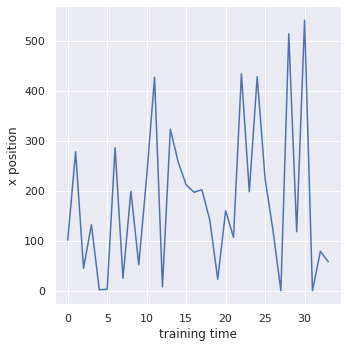

In [14]:
import seaborn as sns
sns.set_theme()
sns.relplot(data=ep_lengths, kind="line").set(xlabel='training time', ylabel='x position')